# Sheet 4

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

## 1 Learning with pytorch

By hand.

(a)

In [ ]:
# TODO: manual check of intermediate gradients with torch.autograd.grad
x = torch.tensor([1.5, 0.5], requires_grad=True)
L = (np.sin(x[0]/x[1]) + x[0]/x[1] - np.exp(x[1])) * (x[0]/x[1] - np.exp(x[1]))

torch.autograd.grad(L)

NameError: name 'torch' is not defined

(b)

In [ ]:
# TODO: Adam steps

In [ ]:
# TODO: Plot the loss

(c)

In [ ]:
# TODO: Compute gradients

In [ ]:
# TODO: Plot gradients and compare to solution for x1 from part (b)

# 2) Amplitude Regression

In [4]:
# load data
trn_dat = np.load("../../sheet04_data/trn_dat.npy")
trn_amp = np.load("../../sheet04_data/trn_amp.npy")

val_dat = np.load("../../sheet04_data/val_dat.npy")
val_amp = np.load("../../sheet04_data/val_amp.npy")
tst_dat = np.load("../../sheet04_data/tst_dat.npy")
tst_amp = np.load("../../sheet04_data/tst_amp.npy")

print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


(a)

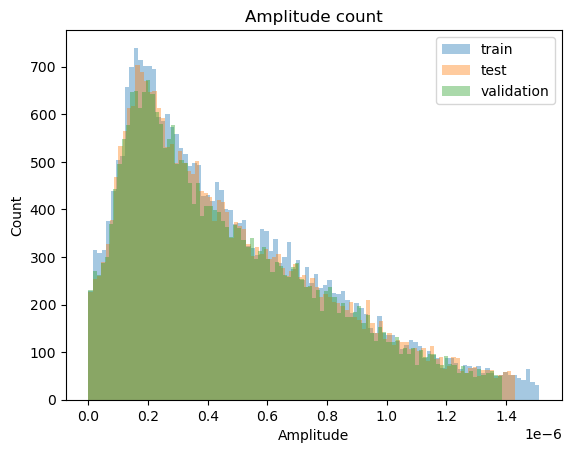

In [5]:
# TODO: Plot amplitudes
plt.hist(trn_amp,range=[0,2 * trn_amp.mean()], bins=100, alpha = 0.4, label='train')
plt.hist(tst_amp,range=[0,2 * tst_amp.mean()], bins=100, alpha = 0.4, label='test')
plt.hist(val_amp,range=[0,2 * val_amp.mean()], bins=100, alpha = 0.4, label='validation')
plt.xlabel('Amplitude')
plt.ylabel('Count')
plt.title('Amplitude count')
plt.legend()

The distribution has a peak at about $0.2\cdot 10^{-6}$ and a long tail towards the right. Also, one can see that the train, test and valitation split are distributed in the same way.

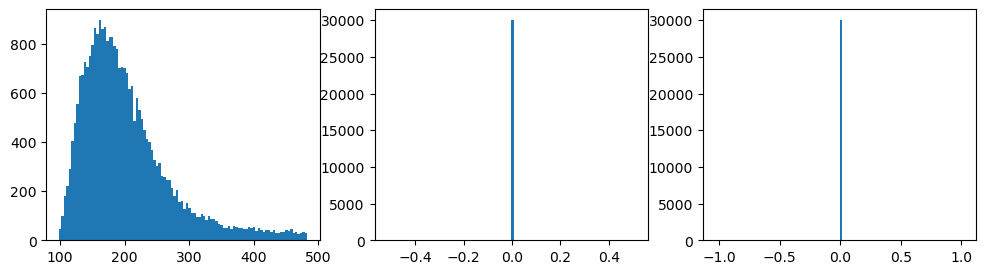

In [7]:
# TODO: Plot incoming momenta
trn_in = trn_dat[:,0,:] + trn_dat[:,1,:]; # sum over incoming particles

fig, axs = plt.subplots(1,3,figsize = (12,3))
_ = axs[0].hist(trn_in[:,0],range=[trn_in[:,0].mean() - trn_in[:,0].std(), trn_in[:,0].mean() + 2 * trn_in[:,0].std()], bins=100)
_ = axs[1].hist(trn_in[:,1],range=[trn_in[:,1].mean() - trn_in[:,1].std(), trn_in[:,1].mean() + trn_in[:,1].std()], bins=100)
_ = axs[2].hist(trn_in[:,2],range=[trn_in[:,2].mean() - trn_in[:,2].std(), trn_in[:,2].mean() + trn_in[:,2].std()], bins=100)


The incoming particles have no center of mass impulse along x and y axis, but only in z axis in which it is again a right tailed distribution with a peak.

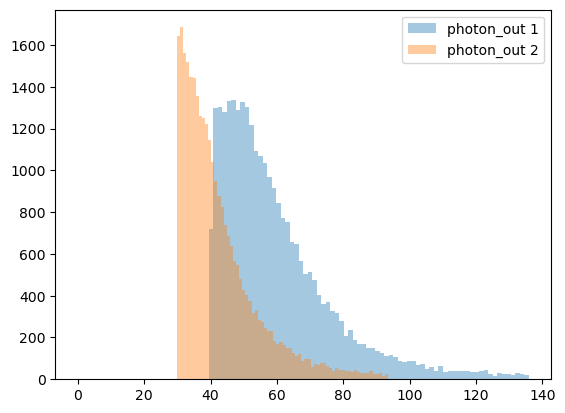

In [8]:
# TODO: Plot photon pTs
pT1 = np.sqrt(trn_dat[:,2,1]**2 + trn_dat[:,2,2]**2)
pT2 = np.sqrt(trn_dat[:,3,1]**2 + trn_dat[:,3,2]**2)

plt.hist(pT1,range=[0,2 * pT1.mean()], bins=100, alpha=0.4, label='photon_out 1')
plt.hist(pT2,range=[0,2 * pT2.mean()], bins=100, alpha=0.4, label='photon_out 2')
plt.legend()

The transverse momentum distribution of the outgoing photons is different for leading and subleading one. However, they are again right-tailed distributions

In [9]:
# TODO: Plot MET
# ?? 

(b)

In [10]:
# flatten datasets
nev = trn_dat.shape[0]
trn_datf = np.reshape(trn_dat, (nev, -1))
val_datf = np.reshape(val_dat, (nev, -1))
tst_datf = np.reshape(tst_dat, (nev, -1))

In [11]:
# TODO: Implement preprocessing
def preprocess_x(x_in):
    x_min = np.min(x_in)
    x_logp1 = np.log(x_in - x_min + 1)
    return (x_logp1 - np.mean(x_logp1)) / np.std(x_logp1)

def preprocess_A(A_in):
    A_log = np.log(A_in)
    return (A_log - A_log.mean()) / A_log.std()

def undo_preprocess_A(A_O1, A_raw):
    A_std = A_raw.std()
    A_mean = A_raw.mean()
    return np.exp(A_O1 * A_std + A_mean)

This transformation is reversible as shown in "undo_process_A". It's image is $\mathcal{O}(1)$ - see below.

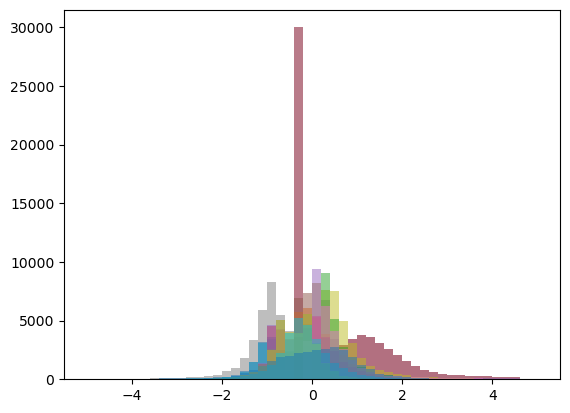

In [12]:
# check that network inputs are O(1)
for i in range(20):
    plt.hist(preprocess_x(trn_datf)[:,i], range=(-5,5), alpha=.5, bins=50)
plt.hist(preprocess_A(trn_amp), range=(-5,5), alpha=.5, bins=50)
plt.show()

In [14]:
# TODO: Implement dataset class
from torch.utils.data import DataLoader

class amp_dataset(torch.utils.data.Dataset):
    
    def __init__(self, data, amp, dtype=torch.float32):
        self.data = torch.tensor(data, dtype=dtype) 
        self.amp = torch.tensor(amp, dtype=dtype)

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]

In [15]:
# TODO: create datasets and dataloaders
trn_dataset = amp_dataset(trn_datf, trn_amp)
val_dataset = amp_dataset(val_datf, val_amp)
tst_dataset = amp_dataset(tst_datf, tst_amp)


trn_dataloader = DataLoader(trn_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=64, shuffle=True)

(c)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [17]:
# TODO: Implement network
class amp_net(nn.Module):
    
    def __init__(self, ipt_dim=20, opt_dim=1, hdn_dim=32, n_layers=2):
        super(amp_net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ipt_dim, hdn_dim),
            nn.ReLU(),
            nn.Linear(hdn_dim, hdn_dim),
            nn.ReLU(),
            nn.Linear(hdn_dim, opt_dim),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [99]:
# TODO: create network
model = amp_net()
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

amp_net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Model has 1761 trainable parameters


In [100]:
# take first batch from train loader
x, A = next(iter(trn_dataloader))
A = torch.unsqueeze(A,1)
print(x.shape, A.shape)

torch.Size([64, 20]) torch.Size([64, 1])


In [103]:
# TODO: Train network on first batch for 10000 iterations
num_iterations = 20000

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
loss_all = np.zeros(num_iterations)
predictions_all = np.zeros(num_iterations)

for iteration in range(num_iterations):
    input_batch =  x
    target_batch =  A

    # Forward pass
    predictions = model(input_batch)

    # Compute the loss
    loss = criterion(predictions, target_batch)
    loss_all[iteration] = loss

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Print the loss every 1000 iterations
    if iteration % 1000 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")


Iteration 0, Loss: 6.7493601818569e-08
Iteration 1000, Loss: 7.845205374223951e-09
Iteration 2000, Loss: 0.0009358067763969302
Iteration 3000, Loss: 3.5409306597955492e-09
Iteration 4000, Loss: 2.2924736242657673e-07
Iteration 5000, Loss: 5.327984453629142e-08
Iteration 6000, Loss: 4.48027140009799e-06
Iteration 7000, Loss: 2.0880713691440178e-07
Iteration 8000, Loss: 1.0490903434856591e-07
Iteration 9000, Loss: 9.426048386274033e-09
Iteration 10000, Loss: 2.317182890010372e-09
Iteration 11000, Loss: 4.3564443785726326e-07
Iteration 12000, Loss: 3.563753853086382e-05
Iteration 13000, Loss: 3.3538039900804506e-08
Iteration 14000, Loss: 8.970978626621218e-09
Iteration 15000, Loss: 7.574998406312261e-09
Iteration 16000, Loss: 1.1694025747743808e-09
Iteration 17000, Loss: 1.0305808290089757e-10
Iteration 18000, Loss: 5.623886356609376e-10
Iteration 19000, Loss: 1.4578961781808175e-05


torch.Size([64, 1])

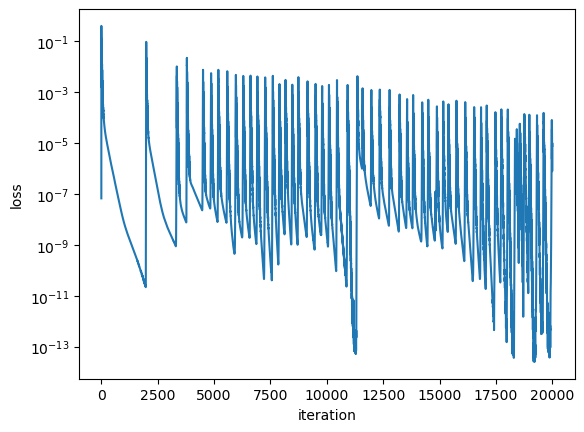

In [104]:
# TODO: Plot loss
plt.plot(loss_all)
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('loss')

predictions.shape

The loss function breaks out from local minima very often. This helps indeed finding better and better parameters.

(array([ 2.,  1.,  0.,  2.,  1.,  1.,  4.,  3., 16., 34.]),
 array([-21795.80078125, -19625.30273438, -17454.80273438, -15284.30371094,
        -13113.8046875 , -10943.30664062,  -8772.80761719,  -6602.30859375,
         -4431.80957031,  -2261.31054688,    -90.81165314]),
 <BarContainer object of 10 artists>)

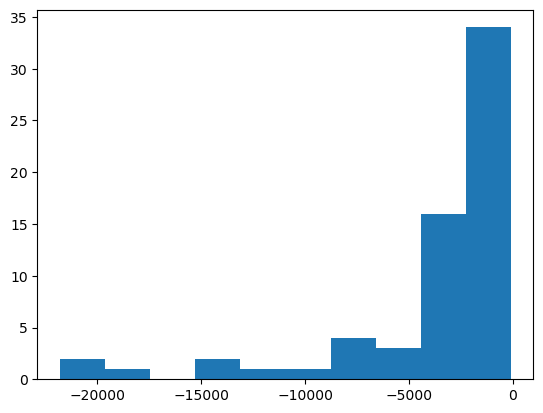

In [22]:
# TODO: Plot (A_predicted - A_true) / A_true
A_predicted = predictions.detach().numpy()[0]
A_true = A.detach().numpy()
plt.hist((A_predicted - A_true) / A_true)


There seems to be a small bias in prediction so that positive values are smaller and larger than truth.

(d)

In [75]:
# TODO: Train network on the full training dataset
tot_iterations = 10000
iter_per_epoch = trn_dataset.__len__() // 64
num_epochs = tot_iterations // iter_per_epoch


def train(num_epochs, dataloader, test_dataloader, model, criterion, optimizer):
    loss_avg_epochs = np.zeros(num_epochs)
    test_loss_epochs = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        model.train(True)
        running_loss = 0.0
        # One epoch
        for i, data in enumerate(dataloader):

            # extract data
            x, A = data
            A = torch.unsqueeze(A,1)


            # forward pass
            predictions = model(x)

            # calc loss
            loss = criterion(predictions, A)

            # zero grad (must do for torch, otherwise grad accumulates)
            optimizer.zero_grad()

            # backprop
            loss.backward()

            # update wheichts
            optimizer.step()

            # document loss and average epoch loss
            running_loss += loss.item()
        
        # after every epoch, calc test loss
        x_test, A_test = next(iter(test_dataloader))
        A_test = torch.unsqueeze(A_test, 1)
        pred_test = model(x_test)
        loss_test = criterion(pred_test, A_test)
        test_loss_epochs[epoch] = loss_test
        
        # print loss
        average_loss = running_loss / iter_per_epoch
        loss_avg_epochs[epoch] = average_loss
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}')
    return loss_avg_epochs, test_loss_epochs


In [97]:
model = amp_net()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Loss = train(num_epochs, trn_dataloader, model, criterion, optimizer)

Epoch 1/21, Loss: 0.3828908060478349
Epoch 2/21, Loss: 0.04090269260968153
Epoch 3/21, Loss: 0.018581499038144756
Epoch 4/21, Loss: 0.009822929137223201
Epoch 5/21, Loss: 0.006191870113327287
Epoch 6/21, Loss: 0.004219203351217752
Epoch 7/21, Loss: 0.0024896501963978046
Epoch 8/21, Loss: 0.0018185956039690834
Epoch 9/21, Loss: 0.001573866216376778
Epoch 10/21, Loss: 0.0011493067644722064
Epoch 11/21, Loss: 0.0007611702664231167
Epoch 12/21, Loss: 0.0005738917063944949
Epoch 13/21, Loss: 0.001128366495213724
Epoch 14/21, Loss: 0.0002764920278835226
Epoch 15/21, Loss: 0.00046127338509904803
Epoch 16/21, Loss: 0.0004644370210449297
Epoch 17/21, Loss: 0.0003143828342598502
Epoch 18/21, Loss: 0.0001061550607404663
Epoch 19/21, Loss: 0.00015422994037915207
Epoch 20/21, Loss: 0.000740476647662146
Epoch 21/21, Loss: 0.0004466815974067561


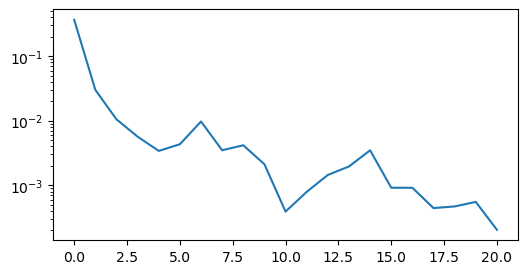

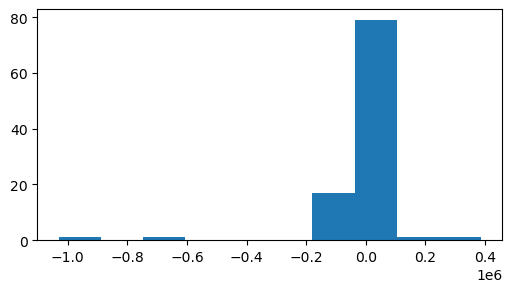

In [77]:
# TODO: Plot loss and amplitude histogram

fig1, ax1 = plt.subplots(figsize = (6,3))
_ = ax1.plot(Loss)
ax1.set_yscale('log')

# sample 100 points for distribution
sample_idx = np.random.choice(np.arange(trn_dataset.__len__() + 1), size=100, replace=False)
A_predicted = model(trn_dataset.data[sample_idx]).squeeze().detach().numpy()
A_true = trn_dataset.amp[sample_idx].detach().numpy()

fig2, ax2 = plt.subplots(figsize = (6,3))
_ = ax2.hist((A_predicted - A_true) / A_true)


Here, the prediction looks less biased.

(e)

In [80]:
# TODO: create dataloaders with reduced dataset
from torch.utils.data import Subset

sample_idx = np.random.choice(np.arange(trn_dataset.__len__() + 1), size=1000, replace=False)
batch_size = 64
trn_dataloader_reduced = DataLoader(Subset(trn_dataset, sample_idx))
val_dataloader_reduced = DataLoader(Subset(val_dataset, sample_idx))
tst_dataloader_reduced = DataLoader(Subset(tst_dataset, sample_idx))

In [94]:
# TODO: Train model on reduced dataset
model = amp_net()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Loss, TLoss = train(100, trn_dataloader_reduced, val_dataloader_reduced, model, criterion, optimizer)

Epoch 1/100, Loss: 2.4554144463078678
Epoch 2/100, Loss: 0.06746220022119834
Epoch 3/100, Loss: 0.024260691175917545
Epoch 4/100, Loss: 0.013948518948366035
Epoch 5/100, Loss: 0.009542324467871828
Epoch 6/100, Loss: 0.005157715842356415
Epoch 7/100, Loss: 0.0008425771406507483
Epoch 8/100, Loss: 0.0003804945246252493
Epoch 9/100, Loss: 0.0001289973141952301
Epoch 10/100, Loss: 7.287222201550196e-05
Epoch 11/100, Loss: 9.10068542975825e-06
Epoch 12/100, Loss: 3.4942929702390206e-05
Epoch 13/100, Loss: 5.5975658629054085e-05
Epoch 14/100, Loss: 3.132274687724666e-06
Epoch 15/100, Loss: 6.185425441874854e-08
Epoch 16/100, Loss: 9.878500580914753e-08
Epoch 17/100, Loss: 7.643235555667107e-07
Epoch 18/100, Loss: 1.4595876016174353e-07
Epoch 19/100, Loss: 8.709768193520686e-07
Epoch 20/100, Loss: 3.026644954271877e-05
Epoch 21/100, Loss: 1.2285940346815236e-05
Epoch 22/100, Loss: 9.126422143255014e-11
Epoch 23/100, Loss: 8.042086206615715e-11
Epoch 24/100, Loss: 9.787715258174935e-11
Epoch 2

In [95]:
# TODO: Evaluate model
def plotloss(Loss, TLoss):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(Loss, label='Loss')
    ax2.plot(TLoss,color='tab:orange',label='Test_Loss')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    fig.legend()

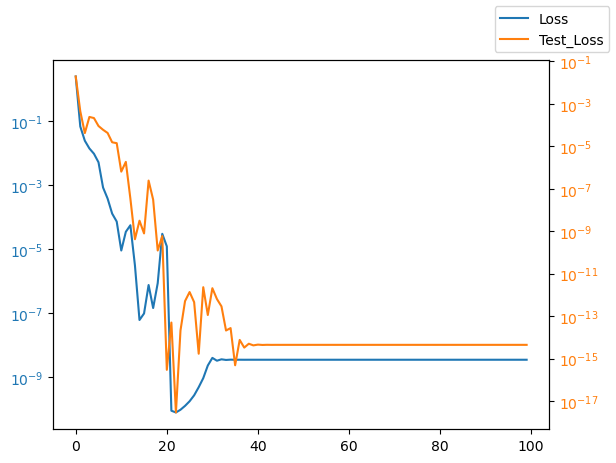

In [96]:
plotloss(Loss, TLoss)

There does not seem to be an overfitting problem here. Nontheless, one can try a dropout as a regularization technique. Dropout avoids that the network relies too heavily on individual neurons, by setting wheights to zero at the last layer with a dropout probability $p$.

In [89]:
# TODO: Implement your regularization approach, train a model and evaluate it
class amp_net_dropout(nn.Module):
    
    def __init__(self, ipt_dim=20, opt_dim=1, hdn_dim=32, n_layers=2,p_dropout=0.5):
        super(amp_net_dropout, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ipt_dim, hdn_dim),
            nn.ReLU(),
            nn.Linear(hdn_dim, hdn_dim),
            nn.ReLU(),
            nn.Dropout(p = p_dropout),
            nn.Linear(hdn_dim, opt_dim),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [90]:
# TODO: Train model on reduced dataset
model = amp_net_dropout()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Loss_drop, TLoss_drop = train(50, trn_dataloader_reduced, val_dataloader_reduced, model, criterion, optimizer)

Epoch 1/50, Loss: 15.735307914883414
Epoch 2/50, Loss: 0.09873691979970688
Epoch 3/50, Loss: 0.013763366005388354
Epoch 4/50, Loss: 0.0035943952975838983
Epoch 5/50, Loss: 0.0008781558071797815
Epoch 6/50, Loss: 0.0001921822019011695
Epoch 7/50, Loss: 0.00015691933668547683
Epoch 8/50, Loss: 0.00032202314269218473
Epoch 9/50, Loss: 0.0003172927900258007
Epoch 10/50, Loss: 0.0004866285646991916
Epoch 11/50, Loss: 0.00015169095912610022
Epoch 12/50, Loss: 3.3648772705905703e-08
Epoch 13/50, Loss: 8.177228620272176e-05
Epoch 14/50, Loss: 4.539470333631438e-05
Epoch 15/50, Loss: 4.2582854619931765e-08
Epoch 16/50, Loss: 1.6876868482986307e-08
Epoch 17/50, Loss: 6.158441950154886e-09
Epoch 18/50, Loss: 1.3315695853600952e-09
Epoch 19/50, Loss: 9.264953455151626e-07
Epoch 20/50, Loss: 3.4125563342083845e-10
Epoch 21/50, Loss: 1.6864314980102558e-10
Epoch 22/50, Loss: 2.605990855439031e-10
Epoch 23/50, Loss: 4.417501463874658e-10
Epoch 24/50, Loss: 8.358089982219497e-10
Epoch 25/50, Loss: 1.9

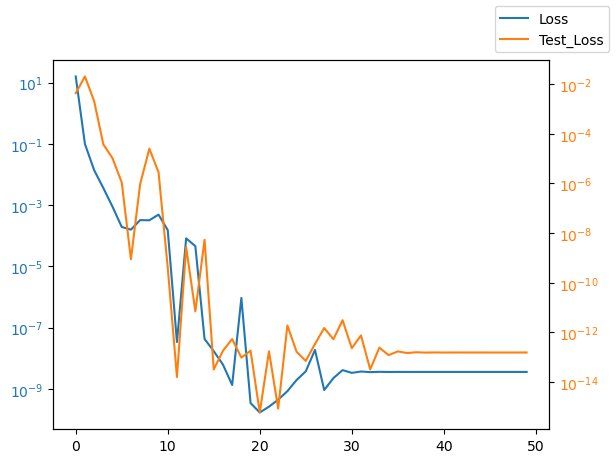

In [91]:
plotloss(Loss_drop, TLoss_drop)